In [1]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from utils.dataset import ChestImage64
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, DataLoader

In [2]:
csv_path = './Data/64px Images/train_labels_64p.csv'
root_path = './Data/64px Images'

In [3]:
transform = Compose([
    Resize((64, 64)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
dataset = ChestImage64(csv_path=csv_path, root_path=root_path, class_name="Lateral", transform=transform)

In [5]:
train_size = round(0.7 * len(dataset))
val_size = round(0.1 * len(dataset))
test_size = round(0.2 * len(dataset))

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


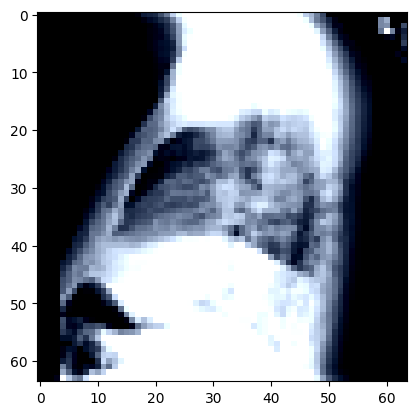

tensor([1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.])


In [7]:
for item in train_loader:
    image = item[0][0].numpy()/2 + 0.5
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.show()
    print(item[1][0])
    break

In [24]:
## define the data
from model.ViT import ViT
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from utils.dataset import ChestImage64
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, DataLoader
from torch import optim
import torch.nn.functional as F
import time

model = ViT(image_size=64, patch_size=8, num_classes=14, channels=3, dim=128, depth=2, heads=8, mlp_dim=128)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
# %%
sum(p.numel() for p in model.parameters())

criterion = torch.nn.BCEWithLogitsLoss()

# %%
def train_epoch(model, optimizer, data_loader, loss_history, device):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output,target)

        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' + '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())


# %%
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

N_EPOCHS = 2

start_time = time.time()

model.to(device)

train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history, device)
    # evaluate(model, test_loader, test_loss_history, device)

Epoch: 1
[    0/21445 (  0%)]  Loss: 0.6791
[ 3200/21445 ( 15%)]  Loss: 0.5374
[ 6400/21445 ( 30%)]  Loss: 0.4533
[ 9600/21445 ( 45%)]  Loss: 0.5325
[12800/21445 ( 60%)]  Loss: 0.4057
[16000/21445 ( 75%)]  Loss: 0.5528
[19200/21445 ( 89%)]  Loss: 0.4648
Epoch: 2
[    0/21445 (  0%)]  Loss: 0.5043
[ 3200/21445 ( 15%)]  Loss: 0.4405
[ 6400/21445 ( 30%)]  Loss: 0.4352
[ 9600/21445 ( 45%)]  Loss: 0.4857
[12800/21445 ( 60%)]  Loss: 0.5329
[16000/21445 ( 75%)]  Loss: 0.5390
[19200/21445 ( 89%)]  Loss: 0.5917


In [25]:
def multi_class_multi_label_accuracy(y_pred, y_true, threshold=0.5):
    # Apply sigmoid function to raw outputs
    y_pred = torch.sigmoid(y_pred)

    # Threshold the predictions
    y_pred = (y_pred > threshold).float()
    # Compute accuracy
    correct = (y_pred == y_true).float()
    accuracy = correct.sum() / (y_true.numel())

    return accuracy


In [26]:
# Import torch and the accuracy function
import torch
total_accuracy  = []
for input, target in test_loader:
    # Compute multi-class multi-label accuracy
    y_pred = model(input)
    accuracy = multi_class_multi_label_accuracy(y_pred, target, threshold=0.5)
    total_accuracy.append(accuracy.item())

print("Accuracy: {:.2f}".format((np.mean(total_accuracy))))


Accuracy: 0.77
